<center>
    <h1> ILI286 - Computación Científica II  </h1>
    <h2> EDP Parabólicas: Diferencias Finitas </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.21 </h2>
</center>

# Tabla de Contenidos
* [Introducción](#intro)
* [EDP Parabólica: Ecuación de Onda](#para)
* [Diferencias Finitas (Forward Difference)](#fd)
* [Diferencias Finitas (Backward Difference)](#bd)
* [Ecuación de calor 1D: Condición de borde de Dirichlet](#heat1d:dirichlet)
* [Ecuación de calor 1D: Condición de borde Periódicas](#heat1d:periodic)
* [Ecuación de calor 2D](#heat2d)
* [Acknowledgements](#acknowledgements)

### Librerias necesarias

In [1]:
%matplotlib notebook

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML

In [2]:
def show(x, t, u):
    Nt = len(t) 
    fig, ax = plt.subplots()
    l, = plt.plot(x, u[:,0],'ko:')
    dx = 0.05*(x[-1]-x[0])
    ymin = u.min().min()
    ymax = u.max().max()
    dy = 0.05*(ymax-ymin)
    ax.set_xlim([x[0]-dx, x[-1]+dx])
    ax.set_ylim([ymin-dy, ymax+dy])
    plt.xlabel("$x$", fontsize=20)
    plt.ylabel("$u(x,t)$", fontsize=20)
    
    def animate(i):
        l.set_ydata(u[:,i])
        return l,

    #Init only required for blitting to give a clean slate.
    def init():
        l.set_ydata(np.ma.array(u[:,0], mask=True))
        return l,

    dt = t[1]-t[0]
    #interval = 4 * 100. * 200/Nt   # So simulations run in the same time regardless of Nt
    interval = 100
    anim = animation.FuncAnimation(
        fig, animate, np.arange(1, Nt),
        init_func=init, interval=interval, blit=True
    )
    return anim

def animate(all_sims, interval=100):
    NumSims = all_sims.shape[0] 
    fig, ax = plt.subplots()
    img = plt.imshow(all_sims[0,:,:], cmap=cm.coolwarm, interpolation='nearest', origin='lower')
    plt.xticks(np.arange(0,101,10), np.linspace(0.,1.0,11))
    plt.yticks(np.arange(10,101,10), np.linspace(0.1,1.0,10))
    plt.colorbar(img)
    
    def animate(i):
        img.set_data(all_sims[i,:,:])
        return img,

    #Init only required for blitting to give a clean slate.
    def init():
        img.set_data(all_sims[0,:,:])
        return img,

    anim = animation.FuncAnimation(
        fig, animate, np.arange(1, NumSims),
        init_func=init, interval=interval, blit=True
    )
    return anim

<div id='para' />

## EDP Parabólica: Ecuación de Onda

En esta sección estudiaremos una clase distinta (y muy común) de EDPs: Parabólicas, en partícular, la **ecuación de calor**:

$$
u_t(x,t) = D\, u_{xx}(x,t).
$$

Este corresponde a un modelo de difusión, que explica como una variable $u(x,t)$ a lo largo de una dimensión espacial $x$, se propaga desde regiones de mayores concentraciones hacia menores concentraciones, a lo largo del tiempo $t$, hasta alcanzar un estado estable.  En este sentido el coeficiente $D$ representa la capacidad de dufisividad, esto es, la fácilidad con la que puede propagarse a lo largo del medio.

<div id='fd' />

## Diferencias Finitas (Forward Difference)

Similar a como se hizo para solucionar numéricamente ODEs, se puede discretizar cada derivada parcial de la PDE con *finite differences*.  Sea la siguiente PDE (ecuación de calor) con sus condiciones de borde:

\begin{align*}
u_t(x,t) &= D\, u_{xx}(x,t) \\
u(x,0) &= f(x) \\
u(a,t) &= l(t) \\
u(b,t) &= r(t) \\
\end{align*}

Un primer enfoque es utilizar *forward difference* para aproximar la derivada temporal, y *centered difference formula* para la segunda derivada espacial, del siguiente modo:

\begin{align}
u_t(x,t) &\approx \frac{1}{k} \left( u(x, t+k) - u(x,t) \right) \\
u_{xx}(x,t) &\approx \frac{1}{h^2} \left( u(x+h,t) - 2 u(x,t) + u(x-h, t)  \right),
\end{align}

siendo $k,h$ el *time step* y *spatial step* respectivamente. Si por simplicidad se denota $w_{i,j} = u(x_i, t_j)$, entonces la discretización de la ecuación queda del siguiente modo:

$$
\frac{1}{k} (w_{i,j+1} - w_{i,j}) \approx \frac{D}{h^2} ( w_{i+1,j}-2 w_{i,j} + w_{i-1,j} ),
$$

con error de aproximación del orden $O(k) + O(h^2)$.

(**Idea**) La idea del método es la siguiente; Dado que por la condiciones de borde y las condiciones iniciales, sabemos los valores de $w_{0,j}, w_{M,j}, w_{i,0} \ \ \forall i,j$, determinar sucesivamente los valores $w_{i,j}$ en los tiempos siguientes,

\begin{align}
t_1:  \ (w_{1,1}, w_{2,1}, &\ldots, w_{M-1,1}) \\
t_2:  \ (w_{1,2}, w_{2,2}, &\ldots, w_{M-1,2}) \\
 & \cdots \\
t_N:  \ (w_{1,N}, w_{2,N}, &\ldots, w_{M-1,N}).
\end{align}

Por medio de la ecuación discretizada anteriormente, es posible obtener un método iterativo que permite conocer los valores aproximados $w_{i,j}$, secuencialmente sobre cada instante siguiente:

$$
\begin{pmatrix}
w_{1,j+1} \\
\\
\vdots \\
\\
w_{m,j+1}
\end{pmatrix}  =
\begin{pmatrix}
1-2\sigma & \sigma & 0 & \cdots & 0 \\
\sigma & 1-2\sigma & \sigma & \ddots & \vdots \\
0 & \sigma & 1-2\sigma & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & \sigma \\
0 & \cdots & 0 & \sigma & 1-2\sigma 
\end{pmatrix}
\begin{pmatrix}
w{1,j} \\
\\
\vdots \\
\\
w_{m,j}
\end{pmatrix}
+
\sigma \begin{pmatrix}
w_{0,j} \\
0 \\ 
\vdots \\
0 \\
w_{m+1,j}
\end{pmatrix} \ \ \  \text{con} \ \sigma = \frac{Dk}{h^2} 
$$

Para ver más detalles, consultar texto guía (*Numerical Analysis, Timothy Sauer, 2nd edition*). Tal método se encuentra implementado en `heat_equation_forward_differences()`.

<div id='bd' />

## Diferencias Finitas (Backward Difference)

Una de las desventajas del método anterior, es que es **condicionalmente estable**, esto es, que converge únicamente bajo ciertas condiciones sobre el tamaño de discretización de la malla: $\sigma = \frac{Dk}{h^2} < \frac{1}{2}$.

Un enfoque distinto y que intenta sobrellevar este problema, es utilizar **backward differences** para la aproximación de derivadas (tal como se hizo en ODEs). Consideremos ahora, que la derivada temporal en la ecuación de calor, es aproximada con el tiempo anterior en vez del tiempo siguiente:

$$
u_t(x,t) \approx \frac{1}{k} \left( u(x,t) - u(x,t-k) \right),
$$
dejando la segunda derivada espacial intacta. Luego se obtiene una ecuación discretizada como se muestra a continuación:

$$
\frac{1}{k}\left( w_{i,j} - w_{i,j-1} \right) = \frac{D}{h^2} \left( w_{i+1,j} - 2 w_{i,j} + w_{i-1,j} \right).
$$

Evaluando esta ecuación y organizando correctamente, se obtiene el método iterativo siguiente:

$$
\begin{pmatrix}
1+2\sigma & -\sigma & 0 & \cdots & 0 \\
-\sigma & 1+2\sigma & -\sigma & \ddots & \vdots \\
0 & -\sigma & 1+2\sigma & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & \sigma \\
0 & \cdots & 0 & -\sigma & 1+2\sigma 
\end{pmatrix}
\begin{pmatrix}
w_{1,j} \\
\\
\vdots \\
\\
w_{m,j}
\end{pmatrix}
=
\begin{pmatrix}
w_{1,j-1} \\
\\
\vdots \\
\\
w_{m,j-1}
\end{pmatrix}
+ 
\sigma 
\begin{pmatrix}
w_{0,j} \\
0 \\ 
\vdots \\
0 \\
w_{m+1,j}
\end{pmatrix}
$$

Para más detalles consultar texto guía (*Numerical Analysis, Timothy Sauer, 2nd edition*). Puede ver la implementación de este método en `heat_equation_backward_differences()`. 

A diferencia del anterior, este no impone ninguna restricción para su convergencia!, esto es, es ** incondicionalmente estable **.

<div id='heat1d:dirichlet' />

## Ecuación de calor 1D: Condición de borde de Dirichlet

Consideremos la siguiente EDP parabólica, para $ x \in [a,b]$ y $t \in [0,T_{max}]$:
\begin{align*}
u_t(x,t) = D\, u_{xx}(x,t)
\end{align*}
\begin{align*}
u(x,0) = f(x)
\end{align*}
\begin{align*}
u(a,t) = l(t)
\end{align*}
\begin{align*}
u(b,t) = r(t)
\end{align*}

In [3]:
def heat_equation_forward_differences(P, Nx, Nt, bc='boundary'):
    """
    Solves the heat equation using forward differences
    """
    if bc=='dirichlet':
        x = np.linspace(P["xmin"], P["xmax"], Nx)
        t = np.linspace(P["tmin"], P["tmax"], Nt)
        dx = x[1]-x[0]
        dt = t[1]-t[0]
        S = P["D"]*dt/dx**2
        print("CFL condition: D*dt/dx^2 = %.1f <= 0.5 ?",S)
        # Storage
        u = np.zeros((Nx, Nt))
        # Time Loop
        for i, ti in enumerate(t):
            if i==0:
                u[:,0] = P["f"](x)
            else:
                u[ 0,i] = P["l"](ti)
                u[-1,i] = P["r"](ti)
                u[1:-1, i] = S*u[:-2, i-1] + (1-2*S)*u[1:-1,i-1]+S*u[2:,i-1]
        return x, t, u

    elif bc=='periodic':
        x = np.linspace(P["xmin"], P["xmax"], Nx)
        t = np.linspace(P["tmin"], P["tmax"], Nt)
        dx = x[1]-x[0]
        dt = t[1]-t[0]
        S = P["D"]*dt/dx**2
        print("CFL condition: D*dt/dx^2 = ",S, " <= 0.5 ?")
        # Storage
        u = np.zeros((Nx, Nt))
        # Time Loop
        for i, ti in enumerate(t):
            if i==0:
                u[:,0] = P["f"](x)
            else:
                u[0, i] = S*u[-2, i-1] + (1-2*S)*u[0,i-1]+S*u[1,i-1]
                u[1:-1, i] = S*u[:-2, i-1] + (1-2*S)*u[1:-1,i-1]+S*u[2:,i-1]
                u[-1, i] = S*u[-2, i-1] + (1-2*S)*u[-1,i-1]+S*u[1,i-1]
        return x, t, u

In [4]:
def heat_equation_backward_differences(P, Nx, Nt, bc='dirichlet'):
    """
    Solves the heat equation using forward differences
    """
    if bc=='dirichlet':
        x = np.linspace(P["xmin"], P["xmax"], Nx)
        t = np.linspace(P["tmin"], P["tmax"], Nt)
        dx = x[1]-x[0]
        dt = t[1]-t[0]
        S = P["D"]*dt/dx**2
        print("CFL condition not required: D*dt/dx^2 = ",S)
        # Constructing the matrix
        A = np.diag(-S*np.ones(Nx-3),-1) + np.diag((1+2*S)*np.ones(Nx-2),0) + np.diag(-S*np.ones(Nx-3),+1)
        # Storage
        u = np.zeros((Nx, Nt))
        # Time Loop
        for i, ti in enumerate(t):
            if i==0:
                u[:,0] = P["f"](x)
            else:
                u[ 0,i] = P["l"](ti)
                u[-1,i] = P["r"](ti)
                b = u[1:-1,i-1].copy()
                b[ 0] += S*u[ 0,i]
                b[-1] += S*u[-1,i]
                u[1:-1, i] = np.linalg.solve(A, b)
        return x, t, u

### Experimentación

In [5]:
f1 = lambda x: np.sin(2*np.pi*x)**2 
l1 = lambda t: t
r1 = lambda t: t
P1 = {"xmin":0, "xmax":1, "tmin":0, "tmax":1.0, "D":1, "f":f1, "l":l1, "r":r1}

f2 = lambda x: 10*np.exp(-(x-.5)**2/0.01) 
l2 = lambda t: 0
r2 = lambda t: 0
P2 = {"xmin":0, "xmax":1, "tmin":0, "tmax":1.0, "D":1, "f":f2, "l":l2, "r":r2}

f3 = lambda x: x 
l3 = lambda t: 0
r3 = lambda t: 0 
P3 = {"xmin":0, "xmax":1, "tmin":0, "tmax":1.0, "D":1, "f":f3, "l":l3, "r":r3}

CFL condition not required: D*dt/dx^2 =  99.0


<IPython.core.display.Javascript object>


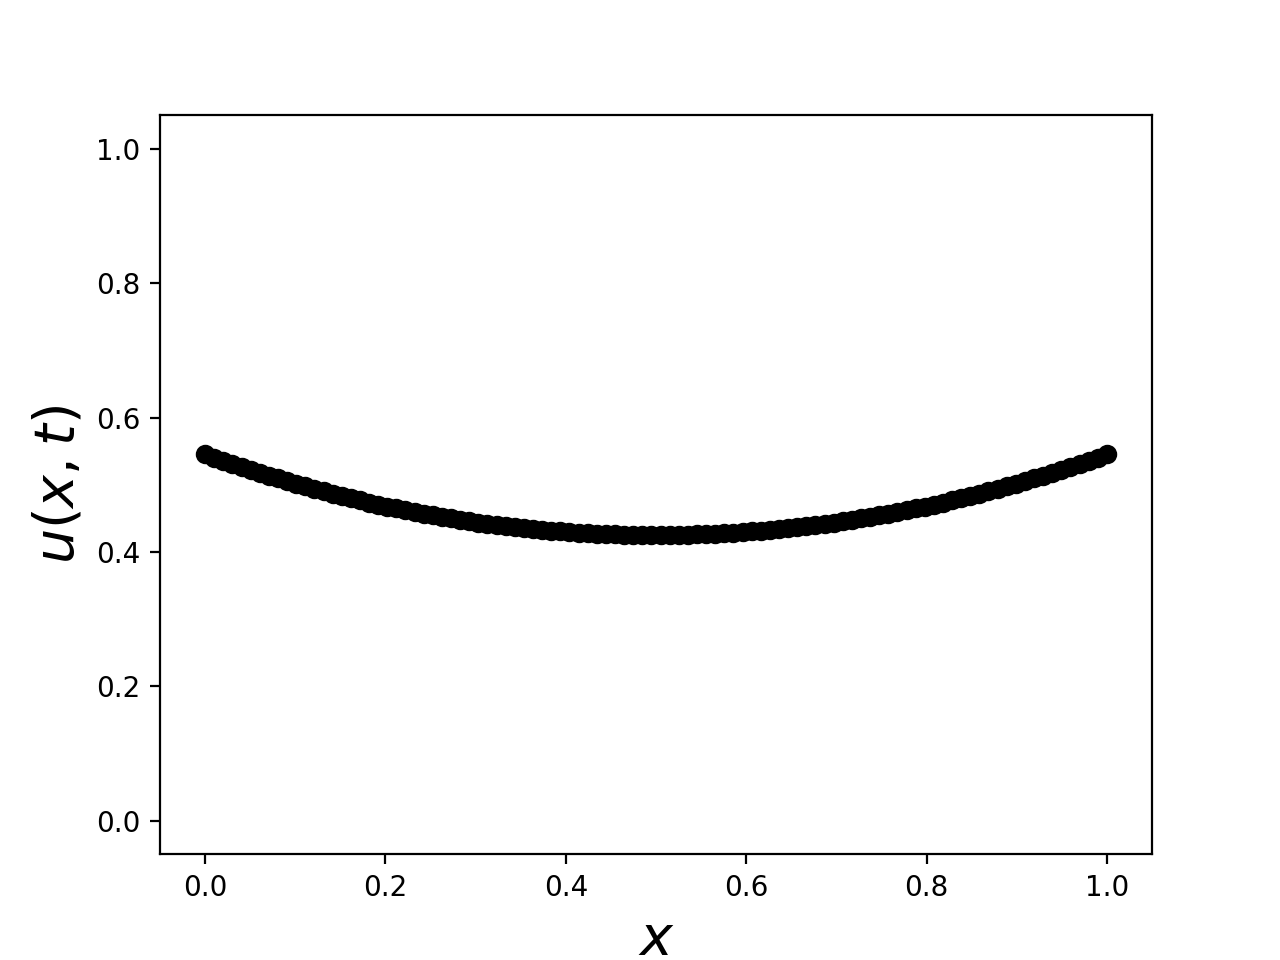

In [6]:
P = P1
#x, t, u = heat_equation_forward_differences(P, 10, 10, bc='dirichlet') # Unstable
#x, t, u = heat_equation_forward_differences(P, 10, 200, bc='dirichlet') # Stable
#x, t, u = heat_equation_forward_differences(P, 100, 20000,bc='dirichlet') # Stable
#x, t, u = heat_equation_backward_differences(P, 10, 10, bc='dirichlet') # Stable
#x, t, u = heat_equation_backward_differences(P, 10, 100, bc='dirichlet') # Stable
x, t, u = heat_equation_backward_differences(P, 100, 100, bc='dirichlet') # Stable

show(x,t,u)

<IPython.core.display.Javascript object>


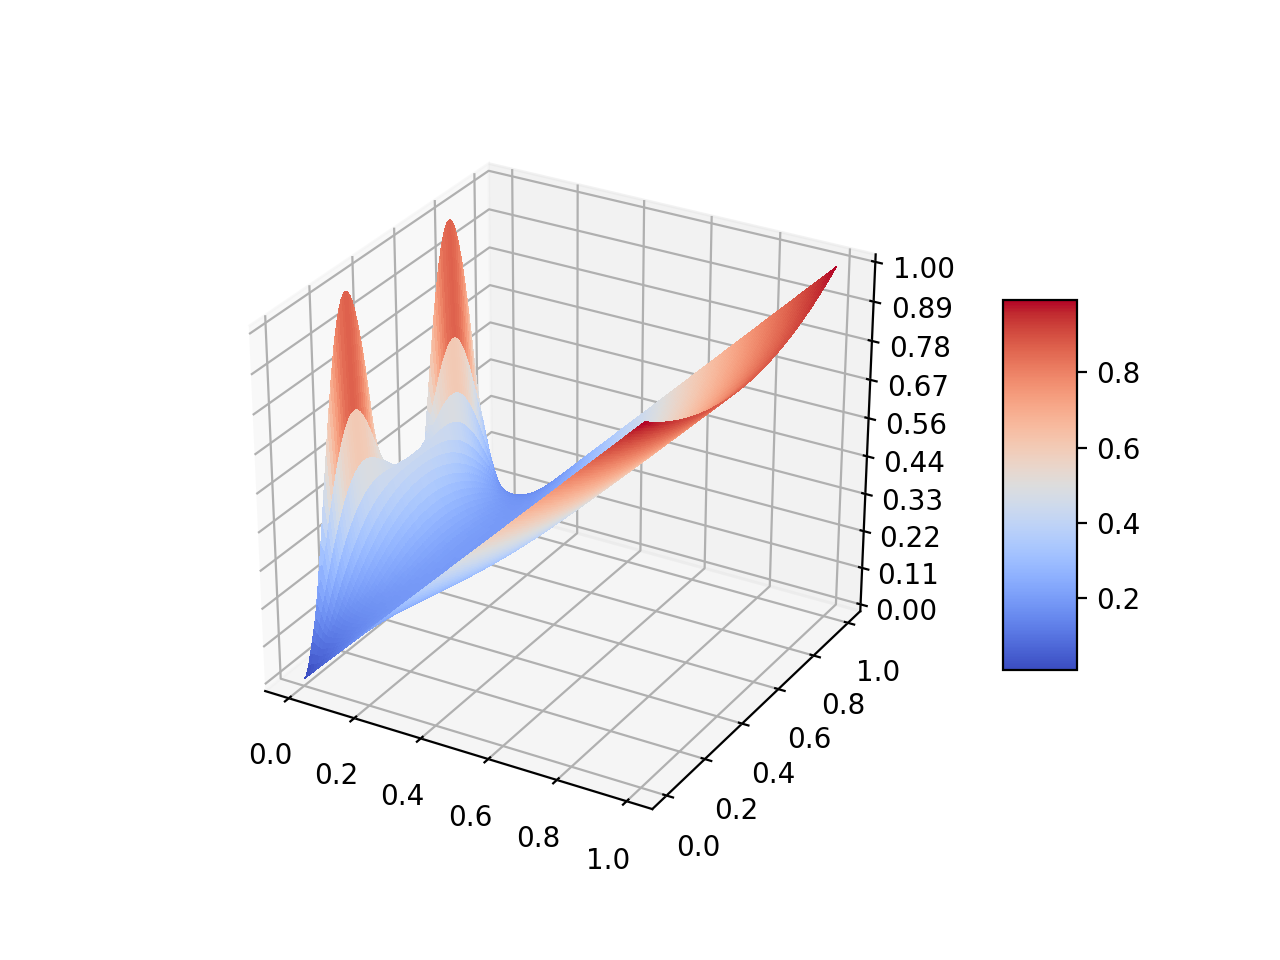

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X,T = np.meshgrid(x,t)
surf = ax.plot_surface(X, T, u, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<div id='heat1d:periodic' />

## Ecuación de calor 1D: Condición de borde Periódica


Consideremos la siguiente EDP parabólica, para $ x \in [a,b]\ \ $ y $t \in [0,T_{max}] \ \ $:
\begin{align*}
u_t(x,t) = D\, u_{xx}(x,t)
\end{align*}
\begin{align*}
u(x,0) = f(x)
\end{align*}
\begin{align*}
u(-x,t) = u(1-x,t)
\end{align*}


La condición de frontera es periódica, esto es, estudiamos la evolución de la temperatura en un anillo,
por lo que consideramos que para $u(-x,t) = u(1-x,t)$

In [8]:
f1 = lambda x: np.sin(2*np.pi*x)**2 
P1 = {"xmin":0, "xmax":1, "tmin":0, "tmax":1.0, "D":1, "f":f1}

f2 = lambda x: 10*np.exp(-(x-.5)**2/0.01) 
P2 = {"xmin":0, "xmax":1, "tmin":0, "tmax":1.0, "D":1, "f":f2}

f3 = lambda x: x 
P3 = {"xmin":0, "xmax":1, "tmin":0, "tmax":1.0, "D":1, "f":f3}

CFL condition: D*dt/dx^2 =  0.4900745037251862  <= 0.5 ?


<IPython.core.display.Javascript object>


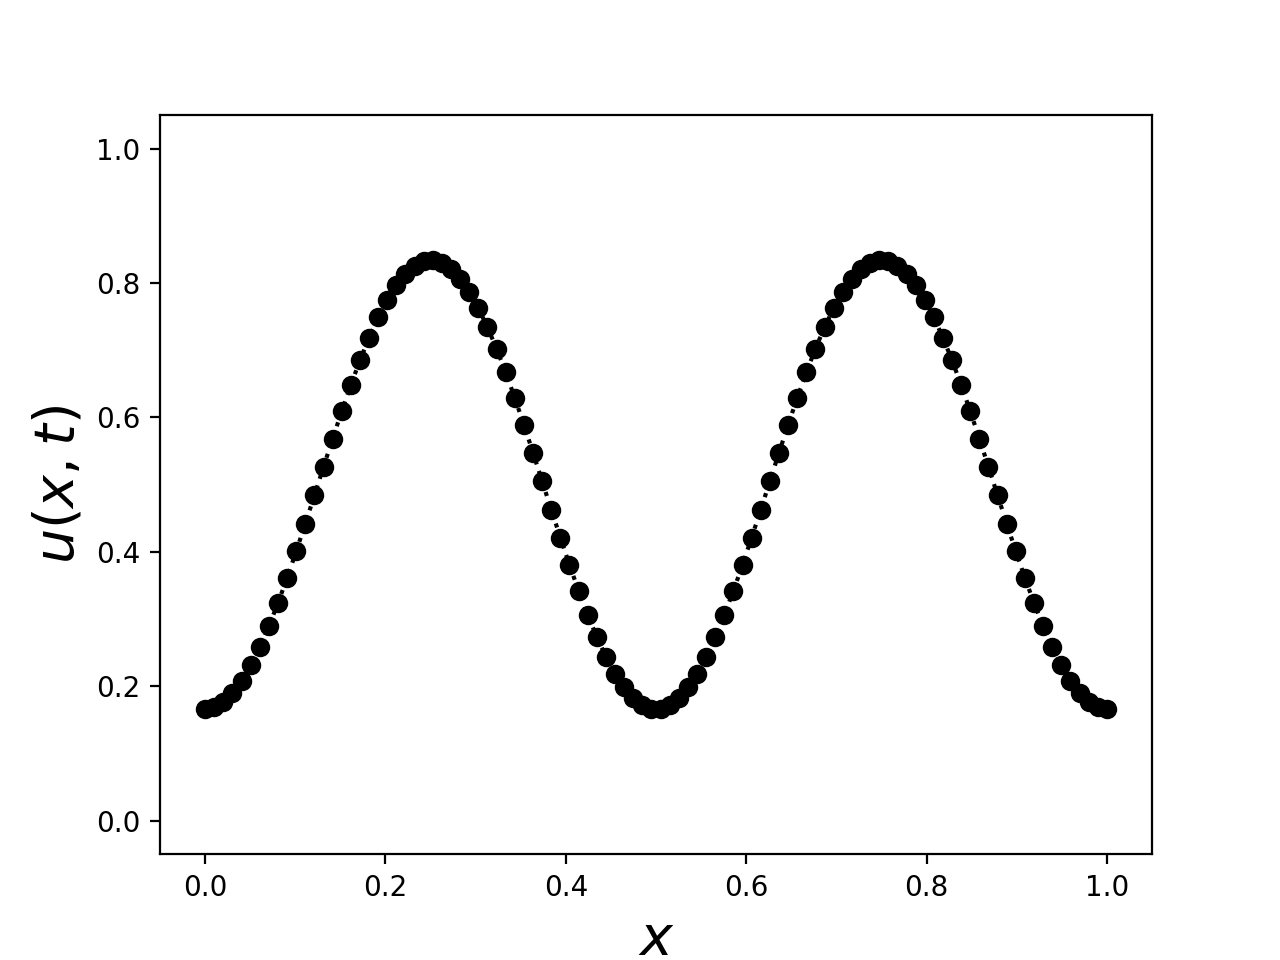

In [9]:
P = P1
#x, t, u = heat_equation_forward_differences(P, 10, 10, bc='periodic') # Unstable
#x, t, u = heat_equation_forward_differences(P, 10, 200, bc='periodic') # Stable
x, t, u = heat_equation_forward_differences(P, 100, 20000, bc='periodic') # Stable
show(x,t,u)

<div id='heat2d' />

## Ecuación de calor 2D

De forma equivalente, la ecuación de calor puede ser planteada para situaciones n-dimensionales. En partícular para en caso 2D puede ser escrita como se muestra a continuación

$$
\frac{\partial u}{\partial t} = D \ \Delta u = D \ \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

con sus respectivas condiciones de borde e iniciales. Las funciones que se muestran a continuación (`evolve()` y `solver()`) se encargan de la resolución *explícita* e *iterativa* del la ecuación 2D.

In [10]:
# This is the 2D version of Explicit Finite Differences
def evolve(u_new, u_old, dt, D, dx2, dy2):
    u_new[1:-1, 1:-1]  = u_old[1:-1, 1:-1] 
    u_new[1:-1, 1:-1] += D * dt * (u_old[2:, 1:-1] - 2*u_old[1:-1, 1:-1] + u_old[:-2, 1:-1]) / dx2 
    u_new[1:-1, 1:-1] += D * dt * (u_old[1:-1, 2:] - 2*u_old[1:-1, 1:-1] + u_old[1:-1, :-2]) / dy2
    return u_new

####################################################
# MAIN 2D-PARABOLIC FUNCTION SOLVER
####################################################
def solver(u0, D=1., Nx=100, Ny=100, num_steps=10000):
    dx = 1./Nx
    dy = 1./Ny
    dx2 = dx**2
    dy2 = dy**2
    
    # For stability, this is the largest interval possible
    # for the size of the time-step:
    dt = 1.0*dx2*dy2 / ( 2*D*(dx2+dy2) )
    
    u_aux = u0
    u = np.zeros([Nx,Ny])
    all_sims = np.zeros([num_steps, Nx, Ny])
    
    # Iterative step
    for n in range(num_steps):
        evolve(u, u_aux, D, dt, dx2, dy2)
        u_aux = u
        all_sims[n,:,:] = u
    
    return all_sims

A continuación se genera como condición inicial, un distribución de *temperatura* con una distribución en forma de anillo en un dominio $[0,1]\times [0,1]$. **Pruebe variando los parámetros!**.

In [11]:
####################################################
# Initial conditions generation: Ring distribution
####################################################
Ri = 0.05 # Internal Radii
Re = 0.10 # External Radii
Nx = 100
Ny = 100
dx = 1./Nx # Interval size in x-direction.
dy = 1./Ny # Interval size in y-direction.
D = 1.   # Diffusion constant.

u0 = np.zeros([Nx,Ny])

# Now, set the initial conditions (ui).
for i in range(Nx):
    for j in range(Ny):
        v=np.array([i*dx-0.5,j*dy-0.5])
        C1 = np.linalg.norm(v,1) <= np.sqrt(Re)
        C2 = np.linalg.norm(v,1) >= np.sqrt(Ri)
        if C1 and C2 : u0[i,j] = 1

<IPython.core.display.Javascript object>


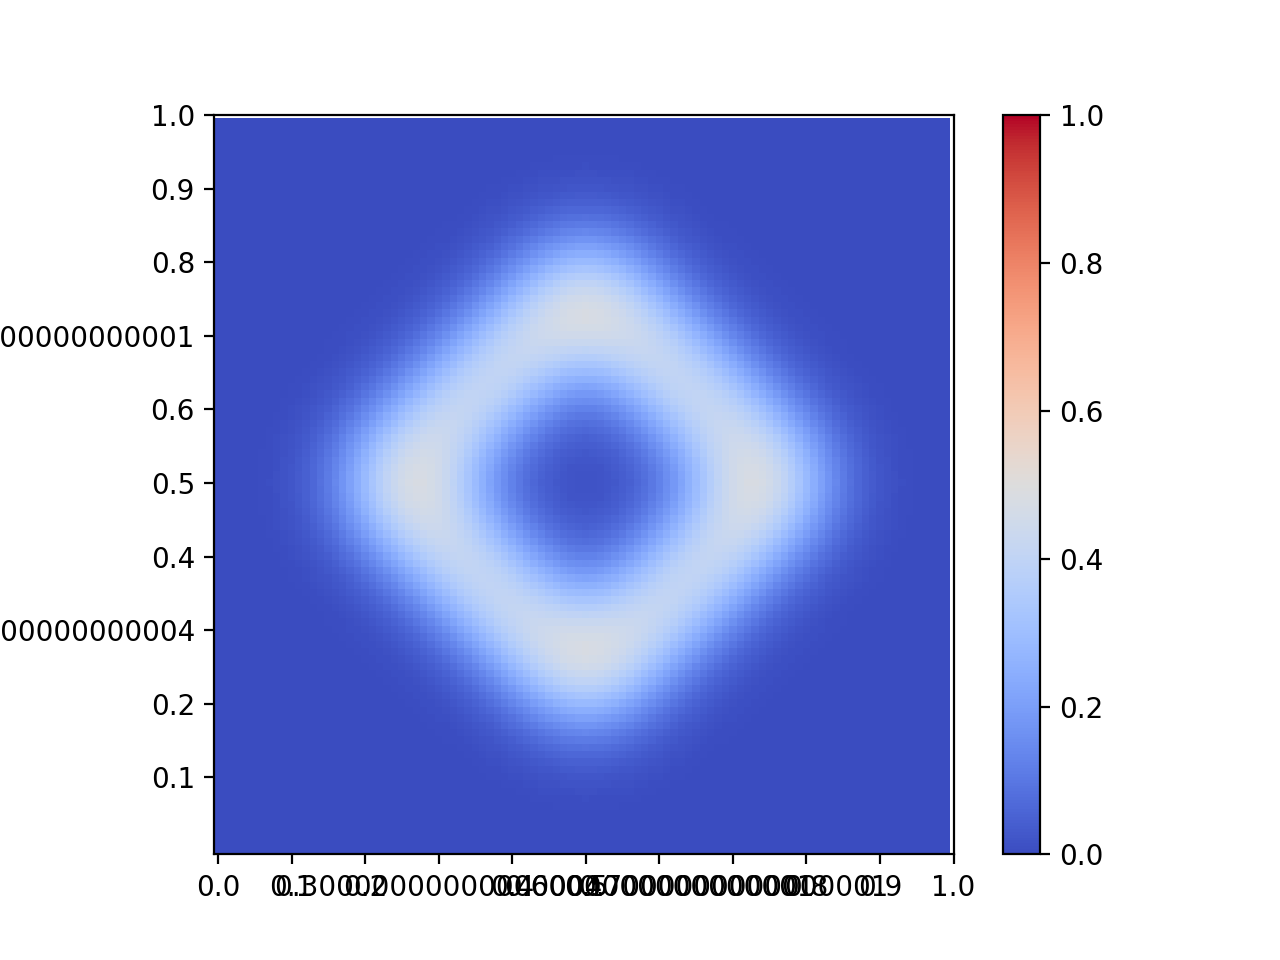

In [12]:
####################################################
# ANIMATION
####################################################
all_sims = solver(u0)
animate(all_sims, interval=50)

In [13]:
########################################################
# Initial conditions generation: Write your own IC here
########################################################
x,y = np.meshgrid(np.linspace(0.,1.,Nx), np.linspace(0.,1.,Ny), sparse=True)

# initial condition
f0 = lambda x,y : 10*np.sin(8*np.pi*x)*np.sin(8*np.pi*y)
u0 = f0(x,y)

<IPython.core.display.Javascript object>


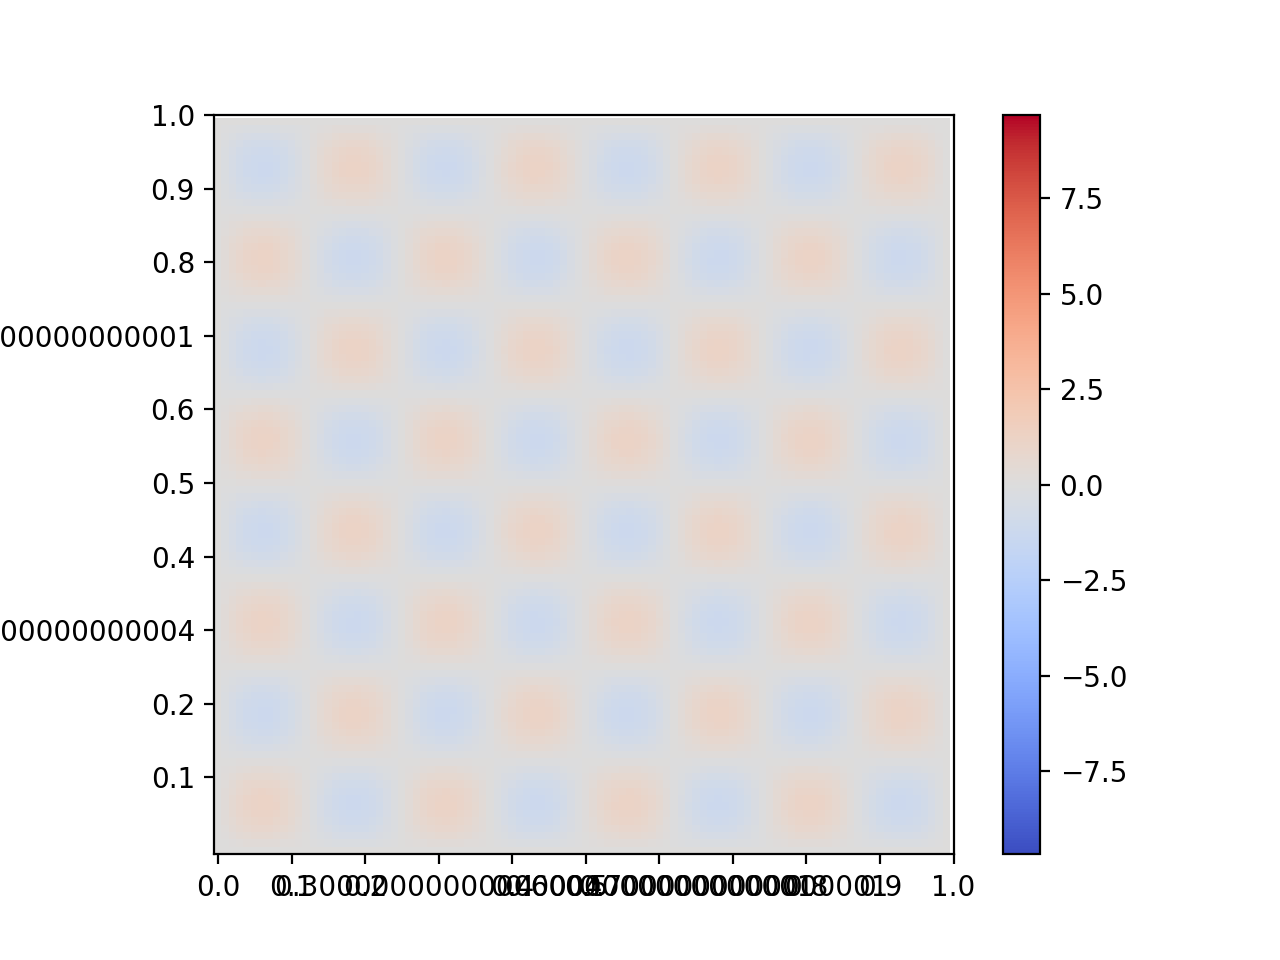

In [14]:
####################################################
# ANIMATION
####################################################
all_sims = solver(u0)
animate(all_sims, interval=50)

<div id='acknowledgements' />

# Acknowledgements
* _Material creado por profesor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _y ayudantes: Alvaro Salinas y Martín Villanueva. DI UTFSM. Noviembre 2016._

***
### DISCLAIMER ###

El presente notebook ha sido creado para el curso **ILI286 - Computación Científica 2**, del [Departamento de Informática](http://www.inf.utfsm.cl/), [Universidad Técnica Federico Santa María](http://www.utfsm.cl/). 

El material ha sido creado por Claudio Torres <ctorres@inf.utfsm.cl> y Sebastian Flores <sebastian.flores@usm.cl>, y es distribuido sin restricciones. En caso de encontrar un error, por favor no dude en contactarnos.

[Update 2016] (Martín) Notebook creado como una fusión de las tres partes anteriores. Agregado contexto / Marco teórico. Agregadas/Arregladas animaciones de los experimentos 1D. Se agregó la simulación y animación en 2D de distribución de temperatura en forma de anillo. 
***